# Advanced Certification Programme in AI and MLOps
## A programme by IISc and TalentSprint
### Assignment: Research to Production Environment: Experimentation_Phase : 1. Data_Exploration & Preliminary Model


## Learning Objectives


At the end of the experiment you will be able to:
* Understand & explore the data
* Perform data preprocessing
* Apply  ML algorithms on **Titanic** dataset



## Dataset Description

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of many passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

[ Data Set Link: Kaggle competition](https://www.kaggle.com/competitions/titanic)

<br/>

### Data Set Characteristics:

**PassengerId:** Id of the passengers

**Survived:** Survived or Not, information

**Pclass:** Socio-economic status (SES)
  * 1st = Upper
  * 2nd = Middle
  * 3rd = Lower

**Name:** Surname, first names of the Passengers

**Sex:** Gender of the passengers

**Age:** Age of the passengers

**SibSp:**	No. of siblings/spouse of the passenger aboard the Titanic

**Parch:**	No. of parents/children of the passenger aboard the Titanic

**Ticket:**	Ticket number

**Fare:** Passenger fare

**Cabin:**	Cabin number

**Embarked:** Port of Embarkation
  * S = Southampton
  * C = Cherbourg
  * Q = Queenstown


## Problem Statement

Build a predictive model that answers the question: “what sort of people were more likely to survive?” using titanic's passenger data (ie name, age, gender, socio-economic class, etc).

In [2]:
# @title Download the datasets
from IPython import get_ipython

ipython = get_ipython()

notebook="U1_MH1_Data_Munging" #name of the notebook

def setup():
    from IPython.display import HTML, display
    ipython.magic("sx wget https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/titanic.csv")
    ipython.magic("sx wget https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/test_titanic.csv")
    print("Data downloaded successfully")
    return

setup()

/var/folders/vs/6l92ypwj3sbc973853q9w9w00000gn/T/ipykernel_4802/1587321599.py:10: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("sx wget https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/titanic.csv")
/var/folders/vs/6l92ypwj3sbc973853q9w9w00000gn/T/ipykernel_4802/1587321599.py:11: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("sx wget https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/test_titanic.csv")


Data downloaded successfully


In [3]:
!ls

Env_setup_VSCode.pdf
Experimentation_Phase_1_Data_Exploration.ipynb
Experimentation_Phase_2_Pipeline_Building.ipynb
M3-W1-AST1.pdf
ReadMe - Module 03 - Assignment_1.pdf
project
test_titanic.csv
test_titanic.csv.1
titanic.csv
titanic.csv.1


List of files present

**Note:** Use titanic.csv for training & testing purpose and Titanic_Test.csv for submitting the prediction on Kaggle competition.

## Import Required Packages

In [4]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt

# to persist the model and the scaler
import joblib

In [5]:
# ========== NEW IMPORTS FOR PIPELINE BUILDING ========

# pipeline
from sklearn.pipeline import Pipeline

# for the preprocessors
from sklearn.base import BaseEstimator, TransformerMixin

## 1. Load & Explore the Data Set

* Understand different features in the training dataset
* Understand the data types of each columns
* Notice the columns of missing values




In [6]:
# Load the dataset
data = pd.read_csv("./project/titanic_model/datasets/titanic.csv")

In [7]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
# Getting information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Data Cleaning and Processing
## **2. Pre-pipeline Preparation**


 ### 2.1 Working on "SibSp" & "Parch" columns:
Combine columns "SibSp" & "Parch" and create another column that represents the total passengers in one ticket with the name "family_size". In each ticket, there might be Siblings/Spouses (SibSp =Number of Siblings/Spouses Aboard) or Parents/Children (Parch=Number of Parents/Children Aboard ) along with the passenger who booked the ticket.

  

In [9]:
# Define a function that takes a dataframe as a parameter and returns a transformed
# Dataframe
def family_size(data_frame):
  df=data_frame.copy()
  df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
  return df

In [10]:
data=family_size(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  FamilySize   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


### 2.2 Working on "Cabin" column:
Find unique entries in the Cabin column. We can label all passengers in two categories having a cabin or not. Check the data type(use: type) of each entry of the Cabin. Convert a string data type into '1' i.e. passengers with cabin and others into '0' i.e. passengers without cabin.  Write a function for the above operation and apply it to the cabin column and create another column with the name " Has_cabin" containing only 0 or 1 entries.





In [11]:
# Write a function that takes dataframe as a parameter and returns the transformed
# Dataframe after binary encoding of the values of 'Cabin' column
def process_cabin(data_frame):
  df=data_frame.copy()
  f1=lambda x: 0 if type(x) == float else 1 ## Ternary Expression
  df['Has_cabin']=df['Cabin'].apply(f1)
  return df

In [12]:
data=process_cabin(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  FamilySize   891 non-null    int64  
 13  Has_cabin    891 non-null    int64  
dtypes: float64(2), int64(7), object(5)
memory usage: 97.6+ KB


### 2.3 Working on "Name" column :
Fetch titles from the name. We can map these titles with numbers and convert them into an integer by mapping with relative numbers. Use: concept of the regular expression.

In [13]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'

In [14]:
get_title('heranl Mr.')

'Mr'

In [15]:
data['Name'].apply(get_title)

0         Mr
1        Mrs
2       Miss
3        Mrs
4         Mr
       ...  
886    Other
887     Miss
888     Miss
889       Mr
890       Mr
Name: Name, Length: 891, dtype: object

In [16]:
data['Title'] = data['Name'].apply(get_title)

In [17]:
data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], dtype=object)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  FamilySize   891 non-null    int64  
 13  Has_cabin    891 non-null    int64  
 14  Title        891 non-null    object 
dtypes: float64(2), int64(7), object(6)
memory usage: 104.5+ KB


In [19]:
# drop unnecessary variables

data.drop(labels=['PassengerId','Name','SibSp','Parch','Ticket','Cabin'], axis=1, inplace=True)

# display data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    object 
 3   Age         714 non-null    float64
 4   Fare        891 non-null    float64
 5   Embarked    889 non-null    object 
 6   FamilySize  891 non-null    int64  
 7   Has_cabin   891 non-null    int64  
 8   Title       891 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


## 3: Data Exploration
### Find numerical and categorical variables

In [20]:
target = 'Survived'

In [21]:
# List of numerical columns
vars_num = [c for c in data.columns if data[c].dtypes!='O' ]#and c!=target]

# List of categorical columns
vars_cat = [c for c in data.columns if data[c].dtypes=='O']

print('Number of numerical variables: {}'.format(len(vars_num)),":" , vars_num)

print('Number of categorical variables: {}'.format(len(vars_cat)),":" , vars_cat)


Number of numerical variables: 6 : ['Survived', 'Pclass', 'Age', 'Fare', 'FamilySize', 'Has_cabin']
Number of categorical variables: 3 : ['Sex', 'Embarked', 'Title']


#### Find missing values in variables

In [22]:
# first in numerical variables
data[vars_num].isnull().mean()

Survived      0.000000
Pclass        0.000000
Age           0.198653
Fare          0.000000
FamilySize    0.000000
Has_cabin     0.000000
dtype: float64

In [23]:
# now in categorical variables
data[vars_cat].isnull().mean()

Sex         0.000000
Embarked    0.002245
Title       0.000000
dtype: float64

### Determine cardinality of categorical variables

In [24]:
# Unique categories in categorical variables
data[vars_cat].nunique()

Sex         2
Embarked    3
Title       5
dtype: int64

### Determine the distribution of numerical variables

array([[<Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Fare'}>],
       [<Axes: title={'center': 'FamilySize'}>,
        <Axes: title={'center': 'Has_cabin'}>]], dtype=object)

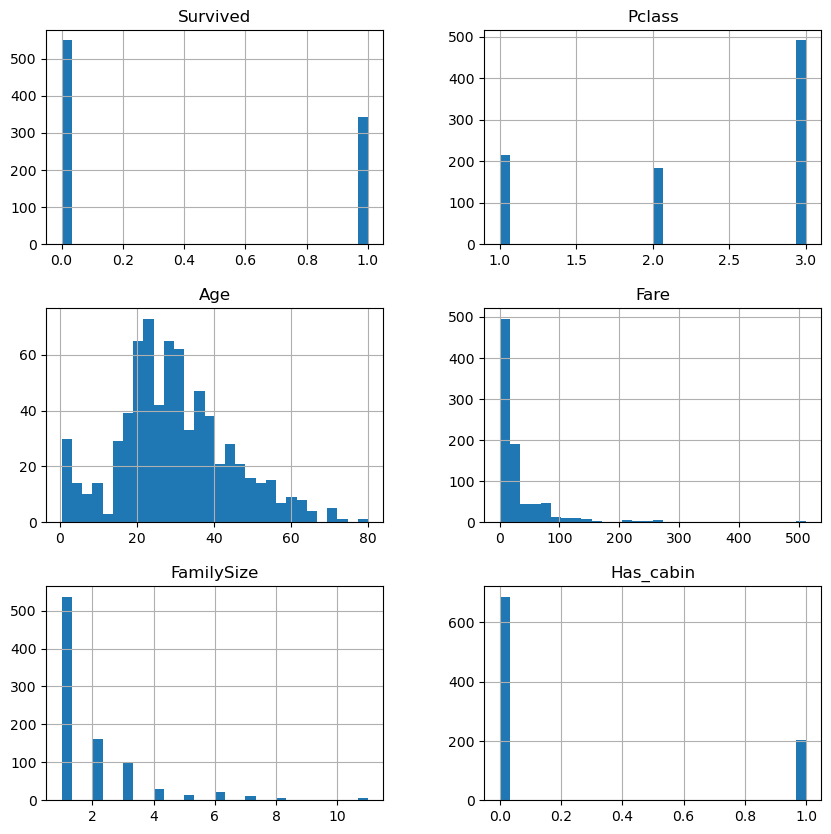

In [25]:
# Plot a Histogram
data[vars_num].hist(bins=30, figsize=(10,10))

## 4: Split the data into train and test set
Note: Apply all your data preprocessing steps in train set first and keep test set aside.

In [26]:
x=data.drop('Survived', axis=1)
y=data['Survived']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
X_train.shape, X_test.shape

((712, 8), (179, 8))

## 5. Feature Engineering

**Numerical variables:  Age column need to fill.**

### 5.1 Working on Age column :
Find the number of NaN entries in the age column and their row index. Calculate the mean, Standard deviation of the Age column and check the distribution of the age column.We can fill the missing values with randomly generated integer values between (mean+Standard deviation, mean-Standard deviation). Use : np.isnan; np.random.randint; concept of slicing dataframe. Convert the age column as an integer data type.



Mean of Age : 29.498846153846156
Std of Age : 14.500058870492348
Count of Nan in Age column : 140


<Axes: ylabel='Frequency'>

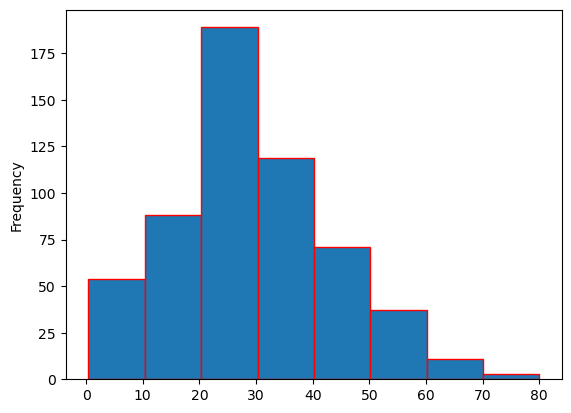

In [27]:
age_avg = X_train['Age'].mean() # Average Age
print("Mean of Age :", age_avg)
age_std = X_train['Age'].std() # Standard Deviation
print("Std of Age :",age_std)
age_null_count = X_train['Age'].isnull().sum() # Number of null records in this feature
print("Count of Nan in Age column :",age_null_count)
## Plotting the histogram plot
X_train['Age'].plot(kind='hist',bins=8,edgecolor='r')

In [28]:
# Define a function, this takes dataframe as a parameter and returns the transformed
# Dataframe, filling the missing values of age feature as discussed above.
def process_age(data_frame):
  df=data_frame.copy()
  np.random.seed(0)
  age_avg = 29.54
  age_std = 14.47
  age_null_count = df['Age'].isnull().sum()
  age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
  df.loc[np.isnan(df['Age']),'Age'] = age_null_random_list
  df['Age'] = df['Age'].astype(int)
  return df

In [29]:
X_train=process_age(X_train)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 331 to 102
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      712 non-null    int64  
 1   Sex         712 non-null    object 
 2   Age         712 non-null    int64  
 3   Fare        712 non-null    float64
 4   Embarked    710 non-null    object 
 5   FamilySize  712 non-null    int64  
 6   Has_cabin   712 non-null    int64  
 7   Title       712 non-null    object 
dtypes: float64(1), int64(4), object(3)
memory usage: 50.1+ KB


**Categorical variables:  Embarked    0.002245 column need to fill.**
### 5.2 Working on "Embarked" column :
The "embarked" column represents the port of Embarkation: Cherbourg(C), Queenstown(Q), and  Southampton(S ). Thus, the entries are of three categories in this column. Fill in the missing rows in this column. We can fill it with the most frequent category. Map these categorical string entries into numerical.



In [30]:
print(X_train.Embarked.unique()) # Unique Categories
print(X_train.Embarked.isnull().sum()) # Number of classes
print(X_train.Embarked.mode()) # Most frequent category

['S' 'C' 'Q' nan]
2
0    S
Name: Embarked, dtype: object


In [31]:
def process_embarked(data_frame):
  df=data_frame.copy()
  df['Embarked'] = df['Embarked'].fillna('S')
  df['Embarked'] = df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
  return df

In [32]:
X_train=process_embarked(X_train)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 331 to 102
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      712 non-null    int64  
 1   Sex         712 non-null    object 
 2   Age         712 non-null    int64  
 3   Fare        712 non-null    float64
 4   Embarked    712 non-null    int64  
 5   FamilySize  712 non-null    int64  
 6   Has_cabin   712 non-null    int64  
 7   Title       712 non-null    object 
dtypes: float64(1), int64(5), object(2)
memory usage: 50.1+ KB


### **Encodings**

### 5.3 Working on "sex" & "Title" columns :
Map the Sex column as 'female' : 0, 'male': 1, and convert it into an integer data type.



In [33]:
X_train['Sex'] = X_train['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

In [34]:
# Map these categorical string entries into numerical.
X_train['Title'] = X_train['Title'].map( {'Mrs': 4, 'Master':3 ,'Miss': 2, 'Mr': 1,'Other':0} ).astype(int)

In [35]:
X_train.head()

,Pclass,Sex,Age,Fare,Embarked,FamilySize,Has_cabin,Title
331,1,1,45,28.5000,0,1,1,1
733,2,1,23,13.0000,0,1,0,1
382,3,1,32,7.9250,0,1,0,1
704,3,1,26,7.8542,0,2,0,1
813,3,0,6,31.2750,0,7,0,2


### 5.4 Apply Standard Scalar

In [50]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled[0,:]

array([-1.61413602,  0.7243102 ,  1.17873926, -0.07868358, -0.54803535,
       -0.55466613,  1.8649363 , -0.62453337])

### 5.5 Create a single function for preprocessing the test set (X_test) and apply it.
#### **Note**: All the pre-processing steps that were applied on the train set before ML Modelling are also applied on the test set before passing through the predict function.

In [37]:
## Create a function
def pre_process(data):
  df=data.copy()

  ## working on Embarked column
  df['Embarked'] = df['Embarked'].fillna('S')

  ## Working on Age column
  np.random.seed(0)
  age_avg = 29.54
  age_std = 14.47
  age_null_count = df['Age'].isnull().sum()
  age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
  df.loc[np.isnan(df['Age']),'Age'] = age_null_random_list
  df['Age'] = df['Age'].astype(int)

  ## Encoding
  df['Sex'] = df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
  df['Embarked'] = df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
  # Mapping tille categorical string entries into numerical.
  df['Title'] = df['Title'].map( {'Mrs': 4, 'Master':3 ,'Miss': 2, 'Mr': 1,'Other':0} ).astype(int)

  #df.Fare=df.Fare.fillna(df.Fare.mean())
  return df

In [38]:
## Applyting above function on X_test
x_test=pre_process(X_test)
x_test.info()
x_test.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 709 to 10
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      179 non-null    int64  
 1   Sex         179 non-null    int64  
 2   Age         179 non-null    int64  
 3   Fare        179 non-null    float64
 4   Embarked    179 non-null    int64  
 5   FamilySize  179 non-null    int64  
 6   Has_cabin   179 non-null    int64  
 7   Title       179 non-null    int64  
dtypes: float64(1), int64(7)
memory usage: 12.6 KB


,Pclass,Sex,Age,Fare,Embarked,FamilySize,Has_cabin,Title
709,3,1,27,15.2458,1,3,0,3
439,2,1,31,10.5000,0,1,0,1
840,3,1,20,7.9250,0,1,0,1
720,2,0,6,33.0000,0,2,0,2
39,3,0,14,11.2417,1,2,0,2


### 5.6 Apply standard Scalar transformation to x_test





In [39]:
x_test_scaled = scaler.transform(x_test) ##
x_test_scaled[0,:]

array([ 0.81303367,  0.7243102 , -0.15342321, -0.33390078,  1.04462249,
        0.63485883, -0.53621134,  1.19787548])

### Exercise 6. Apply Multiple ML Algo. & display the accuracy
#### Expected Accuracy >= 80%

#### **Random Forest**


In [40]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=150, max_depth=5,random_state=42)

In [41]:
# Fit the model
model_rf.fit(X_train_scaled,y_train)

# Predict the model
y_pred = model_rf.predict(x_test_scaled)

# Calculate the accuracy
print("Accuracy(in %):", accuracy_score(y_test, y_pred)*100)

Accuracy(in %): 82.12290502793296
